Parametric and Nonparametric Estimation of Popcorn Kernel Popping Rates 
=========

In [206]:
import pandas as pd
import numpy as np
seed = 42
df = pd.read_csv('./Data/popcorn_pops_custom.csv') # data is computer-generated by ChatGPT under the following assumptions:
    # most kernels pop between 60-75 seconds
    ## some pop earlier ~30-60 seconds 
    ### some pop late ~75-120 seconds
df['pop_time_seconds'] = df['pop_time_seconds'].apply(lambda x: np.random.normal(150,20) if x < 20 else x) # Replace popping times <20 with > 120
trial0 = df[df["trial"] == 0] # use trial0 to illustrate method
print(trial0.head(5))

   trial  pop_time_seconds
0      0            66.809
1      0            66.329
2      0           150.252
3      0            66.329
4      0            64.596


In [207]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

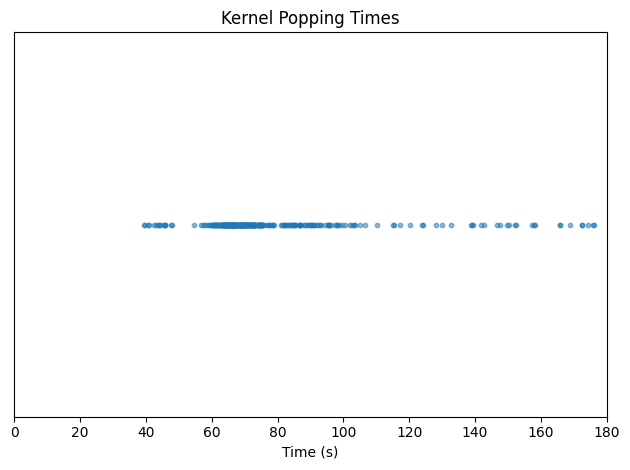

In [276]:
## Kernel Popping Times
pop_times = np.sort(trial0["pop_time_seconds"].values)
plt.scatter(pop_times, [1]*len(pop_times), s = 10, alpha= 0.5)
plt.xlabel("Time (s)")
plt.yticks([])
plt.title("Kernel Popping Times")
plt.xlim((0,180))
plt.tight_layout()
plt.show

In [303]:
inter_pop = np.diff(pop_times) # interpopping waiting times 
np.max(pop_times)
time = np.arange(0,180.01,0.01)
pops = [] # cumulative popped kernels
count = 0 
resid = [] # residual unpopped kernels
n = len(pop_times) # initial unpopped kernels
# Cumulative Distribution Function (CDF) of Popped Kernels
for t in time:
    s = sum(pops)
    if np.any(np.isclose(pop_times,t, atol = 0.005)):
        count += 1 
        pops.append(count)
    else:
        pops.append(count)

# Residual Distribution Function of Unpopped Kernels
for t in time:
    if np.any(np.isclose(pop_times,t,atol = 0.005)):
        n -= 1
        resid.append(n)
    else: 
        resid.append(n)

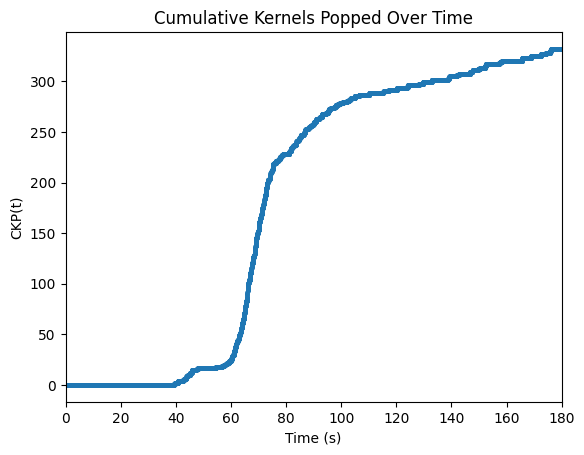

In [304]:
## Discrete Cumulutive Disitrubtion Function (CDF) of Popped Kernels 
plt.scatter(time,pops, s = 5)
plt.xlabel("Time (s)")
plt.ylabel("CKP(t)")
plt.xlim(0,180)
plt.title("Cumulative Kernels Popped Over Time")
plt.show()

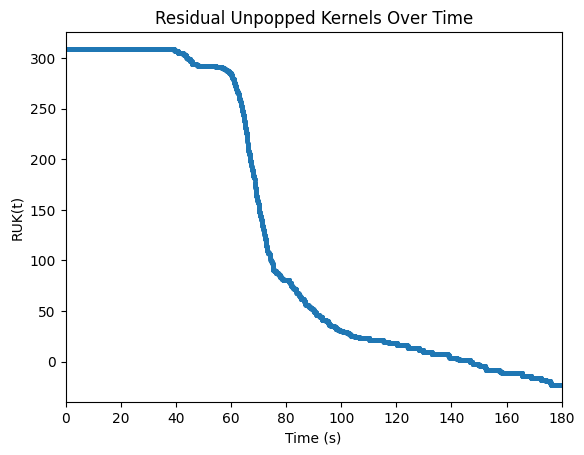

In [305]:
## Residual Disitrubtion Function (RDF) of Unpopped Kernels 
plt.scatter(time,resid, s = 5)
plt.xlabel("Time (s)")
plt.ylabel("RUK(t)")
plt.xlim(0,180)
plt.title("Residual Unpopped Kernels Over Time")
plt.show()

Let $\{X^N(t)\}_{t \geq 0}$ denote a sequence of right-continuous, or càdlàg, piecewise time-homogeneous Poisson processes defined on all $t \in [0,T]$, where each process $X^N(t)$ is constructed with $N$ segments such that on the interval $[t_i, t_{i+1})$, the rate is constant and given by $\lambda_i$. Thus, the associated Poisson counting process is defined by:
 $$ 
 X^N(t + \Delta{t_i}) - X^N(t) \sim \textit{Poisson}(\lambda_{i}\cdot\Delta{t_i})
 $$ 

Assume that for a given deterministic, continuous function $\lambda : [0,T] \to \mathbb{R}_{\geq 0}$, the piecewise constant rates satisfy:
$$
\sup_{t \in [t_i, t_{i+1})} |\lambda_i - \lambda(t)| \to 0 \quad \text{as } N \to \infty
$$
Then the processes $\{X^N(t)\}_{t \geq 0}$ converge in distribution to a single time-inhomogeneous Poisson process $X(t)$ with time-varying intensity $\lambda(t)$ on all $t \in[0,T]$ $\textit{s.t.}$
$
X^N(\cdot) \xrightarrow{d} X(\cdot)$. The limiting process $X(t)$ when $N \rightarrow \infty$ satisfies:
$$
\mathbb{P}(X(t + h) - X(t) = k) = \frac{[\Lambda(t + h) - \Lambda(t)]^k}{k!} \exp\left(-[\Lambda(t + h) - \Lambda(t)]\right), \quad k \in \mathbb{N}
$$
where $\Lambda(t) = \int_0^t \lambda(s) \, ds$ is the cumulative intensity function. Therefore, we can finally conclude:
$$ 
\mathbb{P}(X(t + \Delta{t}) - X(t) = k) = \frac{[\lambda(t)\Delta{t}]^k}{k!} e^{-\lambda(t)\Delta{t}}
$$
Note that we cannot say that $X(t)$ is simply distributed as Poisson with rate $\lambda(t)$ but require the nuance of the cumulative intensity function, $\Lambda(t)$.

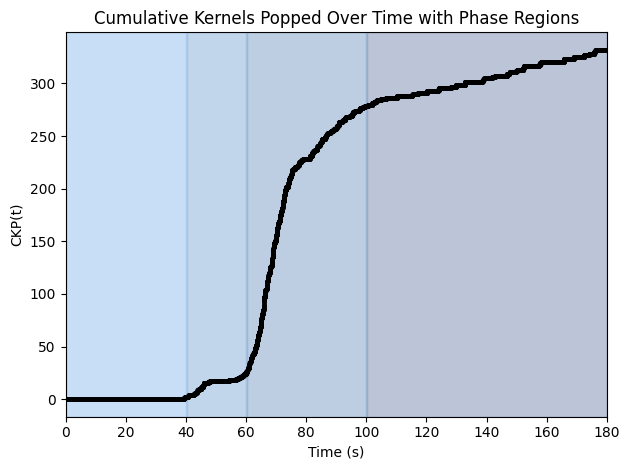

In [306]:
## Discrete Cumulutive Disitrubtion Function (CDF) of Popped Kernels with Shading
shaded_regions = [(0, 40),(40.3, 60),(60.3, 100),(100.3, 180)]
colors = ['#4a90e2', '#357ABD', '#2a5d9f', '#1e3f7d']
for (start, end), color in zip(shaded_regions, colors):
    plt.axvspan(start, end, color=color, alpha=0.3)

plt.scatter(time,pops, s = 5, color = "black")
plt.xlabel("Time (s)")
plt.ylabel("CKP(t)")
plt.xlim(0,180)
plt.title("Cumulative Kernels Popped Over Time with Phase Regions")
plt.tight_layout()
plt.show()

By observation, a suitable choice for N seems to be 4. We can first use a simple nonparametric regression on four intervals of the CDF of kernels popped using a smoothing spline determined by Generalized Cross-Validation (GCV). First, we will fit $\hat{\Lambda_i}(t) \sim \textit{spline}_i(t)$. Then, we differentiate the time-continuous estimation to estimate $\lambda_i(t)$. 

In [217]:
import statsmodels.api as sm
from scipy.stats import t
import scipy.stats as stats
from itertools import combinations
from scipy.interpolate import UnivariateSpline

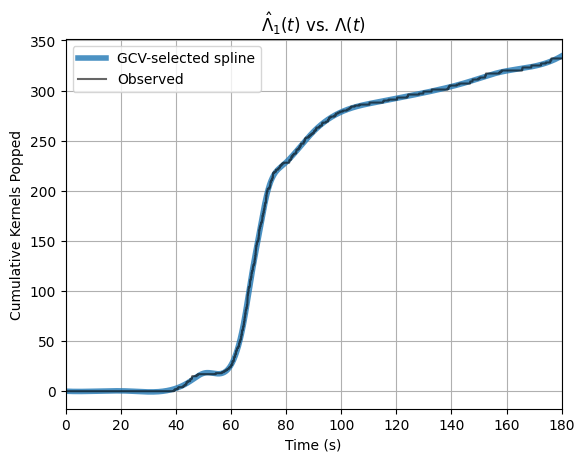

In [307]:
# non-parametric regression on cumulative counts using one smoothing spline
# Automatic s selection using Generalized Cross-Validation (GCV)
x = np.insert(time, 0, 0.0)
y = np.insert(pops, 0, 0.0)
w = np.ones_like(x)
w[0] = 1000  # ensures (0,0) intercept of spline 

# Fit spline
spline = UnivariateSpline(x, y, w=w)
plt.plot(time, spline(time), label='GCV-selected spline', linewidth = 4, alpha = 0.8)
plt.plot(time, pops, color='k', alpha = 0.6, label = 'Observed')
plt.title(r"$\hat{{\Lambda}}_{1}(t)$ vs. $\Lambda(t)$")
plt.ylabel("Cumulative Kernels Popped")
plt.xlabel("Time (s)")
plt.xlim(0,180)
plt.legend()
plt.grid(True)
plt.show()


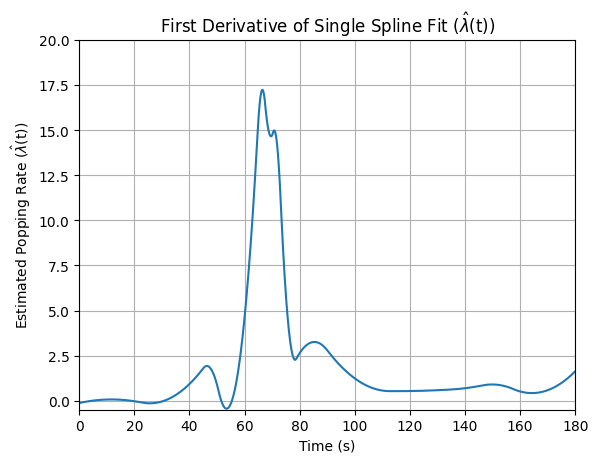

In [311]:
# estimation of lambda(t) via non-parametric regression
Lambda_hat = spline(time)
lambda_hat = spline.derivative()(time) # differentiate Lambda(t) to get lambda(t)

plt.plot(time, lambda_hat, label=r'$\hat{\lambda}(t)$')
plt.xlabel("Time (s)")
plt.ylabel(r"Estimated Popping Rate ($\hat{\lambda}$(t))")
plt.title(r"First Derivative of Single Spline Fit ($\hat{\lambda}$(t))")
plt.grid()
plt.xlim(0,180)
plt.ylim(-0.5,20)
plt.show()

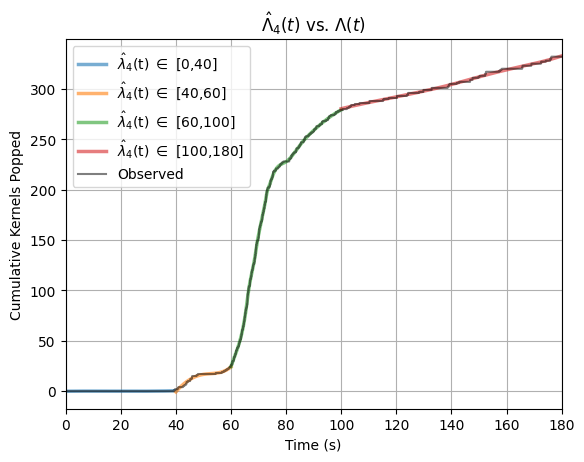

In [312]:
# non-parametric regression on cumulative counts using four smoothing splines
# by observation, we select these four phase regions
regions = [(0, 40),(40, 60),(60, 100),(100, 180)]
pops = np.array(pops) # doesnt require forced (0,0) condition since it's already more robust
splines = []
for (start, end) in regions:
    idx = (time >= start) & (time <= end)
    spline4 = UnivariateSpline(time[idx], pops[idx], k=3) # Automated GCV for spline smoothness s 
    splines.append((spline4, start, end))

for spline, start, end in splines:
    t_region = np.linspace(start, end, 180)
    plt.plot(t_region, spline(t_region), label=rf"$\hat{{\lambda}}_{4}$(t) $\in$ [{start},{end}]", linewidth = 2.5, alpha = 0.6)

# Fit spline
plt.plot(time, pops, color='k', alpha = 0.5, label = 'Observed')
plt.title(r"$\hat{{\Lambda}}_{4}(t)$ vs. $\Lambda(t)$")
plt.ylabel("Cumulative Kernels Popped")
plt.xlabel("Time (s)")
plt.xlim(0,180)
plt.legend()
plt.grid(True)
plt.show()

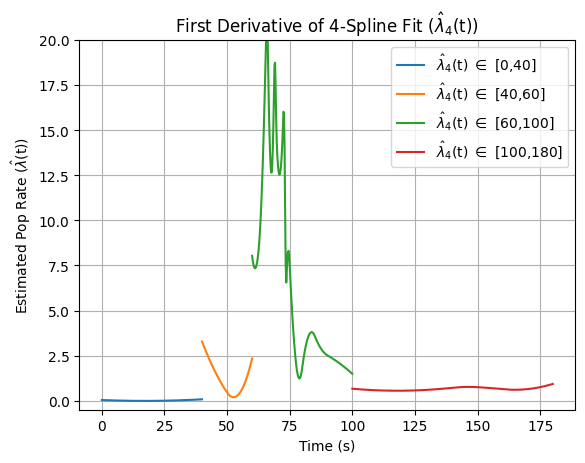

In [313]:
# differentiate splines to get lambda(t)
lambdas = [(spline4.derivative(), start, end) for spline4, start, end in splines]

for deriv_spline, start, end in lambdas:
    t_region = np.linspace(start, end, 180)
    plt.plot(t_region, deriv_spline(t_region), label=rf"$\hat{{\lambda}}_{4}$(t) $\in$ [{start},{end}]")

plt.legend()
plt.title(r"First Derivative of 4-Spline Fit ($\hat{\lambda}_{4}$(t))")
plt.xlabel("Time (s)")
plt.ylabel(r'Estimated Pop Rate ($\hat{\lambda}$(t))')
plt.grid()
plt.ylim(-0.5,20)
plt.show()

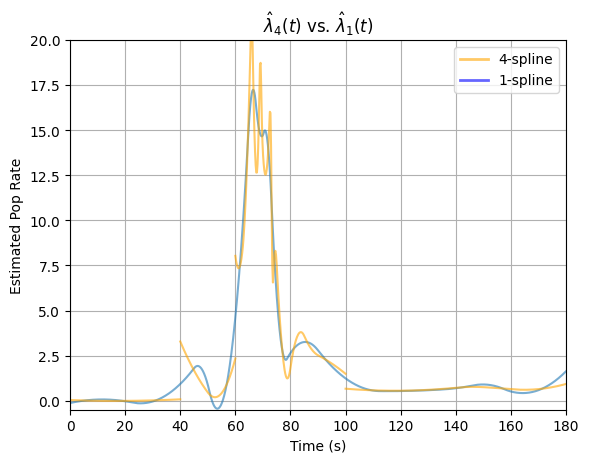

In [322]:
from matplotlib.lines import Line2D

plt.plot(time, lambda_hat, label=r'$\hat{\lambda}(t)$', alpha = 0.6)
for deriv_spline, start, end in lambdas:
    t_region = np.linspace(start, end, 180)
    plt.plot(t_region, deriv_spline(t_region), label=rf"$\hat{{\lambda}}_{4}$(t) $\in$ [{start},{end}]", color = "orange", alpha = 0.6)
custom_lines = [
    Line2D([0], [0], color='orange', lw=2, label="4-spline", alpha = 0.6),
    Line2D([0], [0], color='blue', lw=2, label="1-spline", alpha = 0.6)
]
plt.legend(handles=custom_lines)
plt.xlabel("Time (s)") 
plt.ylabel("Estimated Pop Rate")
plt.title(r"$\hat{{\lambda}}_{4}(t)$ vs. $\hat{{\lambda}}_{1}(t)$")
plt.ylim(-0.5,20)
plt.xlim(0,180)
plt.grid()
plt.show()

We can see that the $N = 4$ spline model is significantly more robust than the $N = 1$ model. Specfiically, the boundary conditions for zero at the origin and infinity  are no longer required, as the 4-spline model achieves this intrisically. 

Alternatively, we can use Bayesian inference on small intervals of data modeled by: 
$$
Y_i \sim \textit{Poisson}(\lambda_i\cdot\Delta{t})
$$

Now that we have determined an approximate time-varying $\lambda(t)$, we can use the conjugate prior of Poisson, the Gamma distribution to smooth our estimated function of $\lambda(t)$. Essentially, at each time $t$, $\lambda(t) \sim \textit{Gamma}(\alpha(t), \beta(t))$. 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


/Users/siddhant/Library/Python/3.12/lib/python/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


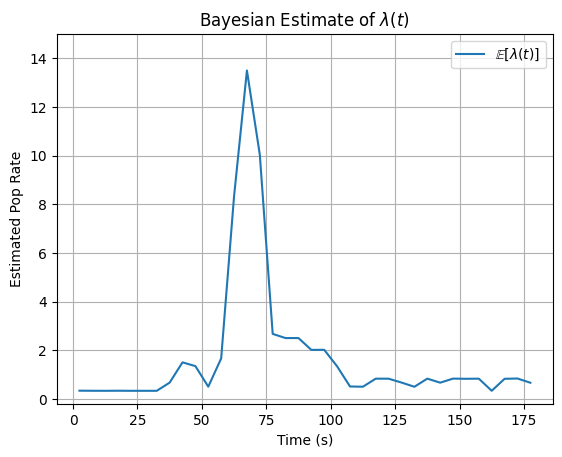

In [318]:
import pymc as pm

# Discretize time into bins of size dt = 5
dt = 5
bins = np.arange(0, max(time) + dt, dt)
counts, _ = np.histogram(pop_times, bins=bins)

with pm.Model() as model:
    lambda_ = pm.Gamma("lambda", alpha=2, beta=1, shape=len(counts)) # Gamma(2,1) prior
    y = pm.Poisson("y", mu=lambda_ * dt, observed=counts)

    trace = pm.sample(1000, tune=1000, target_accept=0.9)

# Posterior mean estimate of lambda(t)
lambda_mean = trace.posterior["lambda"].mean(dim=["chain", "draw"])

midpoints = (bins[:-1] + bins[1:]) / 2
plt.plot(midpoints, lambda_mean, label=r'$\mathbb{E}[\lambda(t)]$')
plt.xlabel("Time (s)")
plt.ylabel("Estimated Pop Rate")
plt.ylim(-0.2,15)
plt.title(r'Bayesian Estimate of $\lambda(t)$')
plt.grid()
plt.legend()
plt.show()

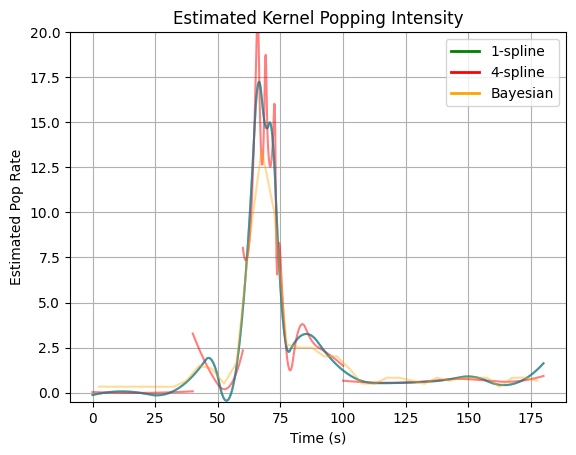

In [321]:
plt.plot(time, lambda_hat, color = "green", alpha = 0.5)
for deriv_spline, start, end in lambdas:
    t_region = np.linspace(start, end, 180)
    plt.plot(t_region, deriv_spline(t_region), color = "red", alpha = 0.5)
plt.xlabel("Time (s)")
plt.ylabel("Estimated Pop Rate")
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label="1-spline"),
    Line2D([0], [0], color='red', lw=2, label="4-spline"),
    Line2D([0], [0], color='orange', lw=2, label="Bayesian")
]
plt.plot(time, lambda_hat, label=r'1-spline', alpha = 0.6)
plt.plot(midpoints, lambda_mean, color = "orange", alpha = 0.4)
plt.title("Estimated Kernel Popping Intensity")
plt.ylim(-0.5,20)
plt.legend(handles = custom_lines)
plt.grid()
plt.show()

The Bayesian estimate offers a better peaked $\lambda(t)$ at $t \approx 60$ seconds however doesn't capture the boundary conditons at $t = 0$ and the limiting behavior as $t \rightarrow \infty$. The 4-spline method seems to overfit significantly. Thus, the single spline model is the most desirable given its computational efficiency and overall convergence at desired limits. 

Next steps: using stochastic theory to calculate the expected time that all the popcorn has popped. Optimizing the loss function (unpopped leftover kernels) with the time waited and potentially burnt popcorn losses. We could calculate $\mathbb{E}_{t \in [0,T]}{X}$ which is the expected kernel popping cycle and potnetially estimating the convergence time to steady state (no more rapid kernel popping). 

Create an ML model that can predict the optimal time of waiting based on the first two pops. Use test/train split and hyperparameter tuning to create model and validate on test popping data. This would essentially allow people to save minutes of waiitng at the microwave becuase they can predict when easily. Natural error in the individual kernels would be the source of the largest error since the data we're using is computer generated. 